In [1]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import numpy as np
import pandas as pd
import scipy.io
from tensorflow import keras as K, nn
import seaborn as sns
from keras.regularizers import l2
import os

2023-12-13 20:47:09.110956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load dataset of our own handwritten letters

In [2]:
def preload(file):
    if file.endswith('.npy'):
        return int(file.split('_')[1].split('.')[0])

In [3]:
# Load all char datasets of own handwriting to create larger dataset
# chars1, chars2, chars3
## These datasets are without spacing (not separating the words)
data1 = np.load('data/training/chars1.npy')
data2 = np.load('data/training/chars2.npy')
data3 = np.load('data/training/chars3.npy')
## Yuqin data, first image did not work very well in the detection, to be discarded
data_yuqin = np.load('data/training/chars2_yuqin.npy')

#np.concatenate
data_total = np.concatenate((data1, data2, data3))
#data_total.shape
data = data_total/255


# List to store all word datasets
words = []
words_dir = os.listdir('data/training/words')

# Sort datasets in /words directory
sorted_words_dir = sorted([preload(file) for file in words_dir])

# Load datasets into words list
for word_index in sorted_words_dir:
    word_dataset = np.load(f'data/training/words/word_'+str(word_index)+'.npy')
    ## Normalize data
    word_dataset = word_dataset/255
    words.append(word_dataset)

## Set true labels

In [4]:
true_labels_file = open('true_labels.txt','r').read()
y = np.array([int(s) for s in true_labels_file.split(',')])

y_word = [[7,14,15,4], [19,7,8,18], [22,99,10,18,99], [5], [11,13,0], [15,17,14,9,4,2,19],
                  [19,7,8,18], [8,18], [0], [99,12,15,11,4], [99,23,19], [19,7,4], [99,99,14,13],
                  [99,17,8,15,19], [0], [19,7,8,17,3], [11,8,13,4], [99], [19,4,23,19],
                  [5,8,13,0,11], [12,4,18,18,0,99], [18,15,0,2,8,13,6],
                  [8,18], [8,12,99,17,19,0,13,19], [7,4,11,14], [22,14,17,11,3],
                  [7,14,15,4], [19,99,99,4], [5], [13,0,11], [15,17,14,9,4,2,19],
                  [22], [14,17,10], [22,4,11,11]]

print("True labels: ", y)
print("Length y_word: ", len(y_word))

True labels:  [ 7 14 15  4 19  7  8 18 22 99 10 18 99  5 11 13  0 15 17 14  9  4  2 19
 19  7  8 18  8 18  0 99 12 15 11  4 99 23 19 19  7  4 99 99 14 13 99 17
  8 15 19  0 19  7  8 17  3 11  8 13  4 99 19  4 23 19  5  8 13  0 11 12
  4 18 18  0 99 18 15  0  2  8 13  6  8 18  8 12 99 17 19  0 13 19  7  4
 11 14 22 14 17 11  3  7 14 15  4 19 99 99  4  5 13  0 11 15 17 14  9  4
  2 19 22 14 17 10 22  4 11 11  0  1  2  3  4  5  6  7  8  9 10 11 12 13
 14 15 16 17 18 19 20 21 22 23 24 25]
Length y_word:  34


### Concatenate all word datasets for on-device training
### Train validation split

In [5]:
all_data = np.concatenate(words)
split = 0.2
N = len(all_data)

X_val_device = all_data[0:int(N*split)]
y_val_device = y[0:int(N*split)]

X_train_device = all_data[int(N*split):N]
y_train_device = y[int(N*split):N]

print(f"Total train data shape: {all_data.shape}")
print(f"X train: {X_train_device.shape}")
print(f"y train: {y_train_device.shape}")
print(f"X val: {X_val_device.shape}")
print(f"y val: {y_val_device.shape}")

np.save('data/training/device/X_train.npy', X_train_device)
np.save('data/training/device/y_train.npy', y_train_device)
np.save('data/training/device/X_val.npy', X_val_device)
np.save('data/training/device/y_val.npy', y_val_device)

Total train data shape: (156, 28, 28)
X train: (125, 28, 28)
y train: (125,)
X val: (31, 28, 28)
y val: (31,)


## Load saved data and plot train/val data

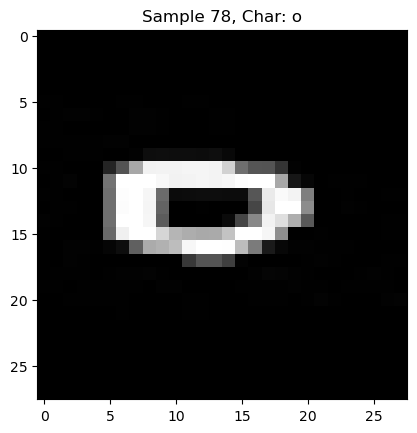

In [6]:
X = np.load('data/training/device/X_train.npy')
y = np.load('data/training/device/y_train.npy')

chars = 'abcdefghijklmnopqrstuvwxyz'

r = np.random.randint(0, len(X))
label = y[r]
if label == 99: true_char = 'undefined'
else: true_char = chars[label]

plt.imshow(X[r,:,:], cmap='gray')
plt.title(f"Sample {r}, Char: {true_char}");

## Labelling data

In [7]:
chars = 'abcdefghijklmnopqrstuvwxyz'
## Unrecognized character gives 99
def encode_char(x):
    try:
        i = chars.index(x)
        return i
    except ValueError:
        return 99

(4, 28, 28)
Char indices:  [22, 4, 11, 11]


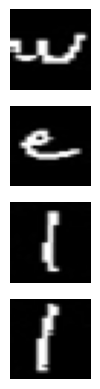

In [8]:
# fig, axes = plt.subplots(10)
# for i in range(10,20):
#     axes[i%10].imshow(data[i,:,:], cmap = "gray")
#     axes[i%10].axis('off')

data = words[33]
print(data.shape)
fig, axes = plt.subplots(len(data))
for i in range(0,len(data)):
    axes[i%10].imshow(data[i,:,:], cmap = "gray")
    axes[i%10].axis('off')
#axes.imshow(data[0,:,:], cmap = "gray")

# Manually set labels...
labels = 'w,e,l,l'.split(',')
# y[60:70] = [encode_char(x) for x in labels]
# print(y)
char_indices = [encode_char(x) for x in labels]
print("Char indices: ", char_indices)

## Show separate words

/tmp/ipykernel_3906/1473766628.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1,N,figsize=(N,2));


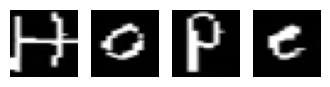

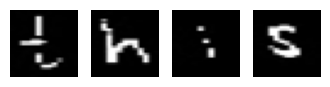

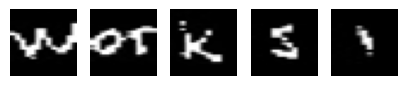

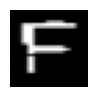

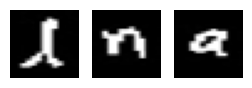

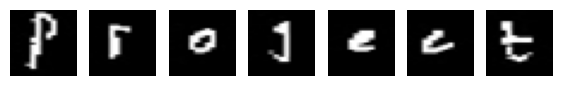

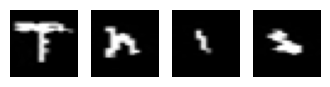

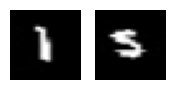

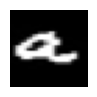

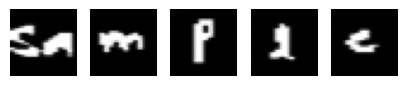

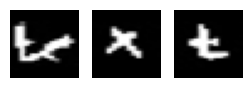

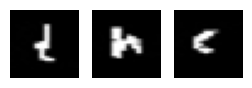

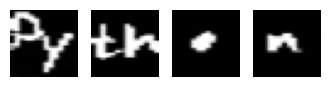

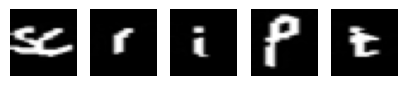

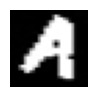

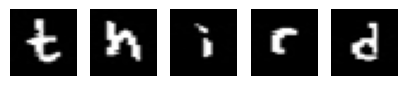

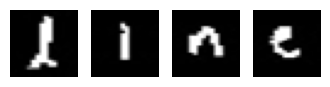

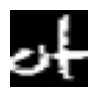

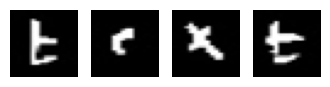

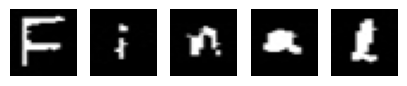

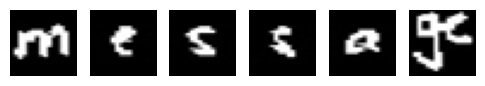

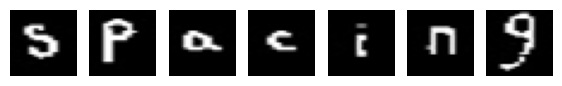

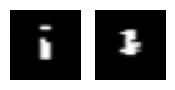

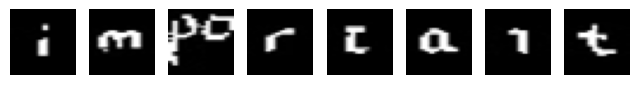

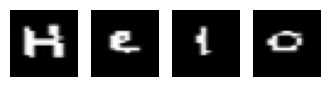

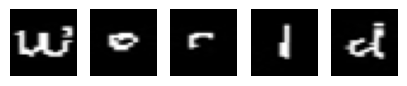

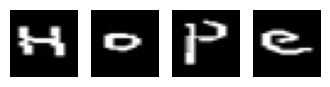

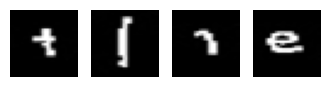

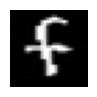

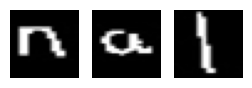

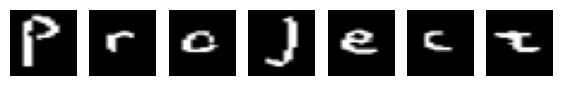

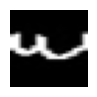

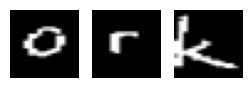

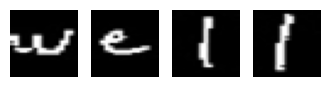

In [9]:
for j in range(0, len(words)):
    word = words[j]
    N = len(word)
    fig, axes = plt.subplots(1,N,figsize=(N,2));
    if N > 1:
        for i in range(0, len(word)):
            axes[i].imshow(word[i,:,:], cmap='gray')
            axes[i].axis('off')
    else:
        axes.imshow(word[0,:,:], cmap='gray')
        axes.axis('off')

## Show data

Char dataset shape:  (4, 28, 28)
Words:  34


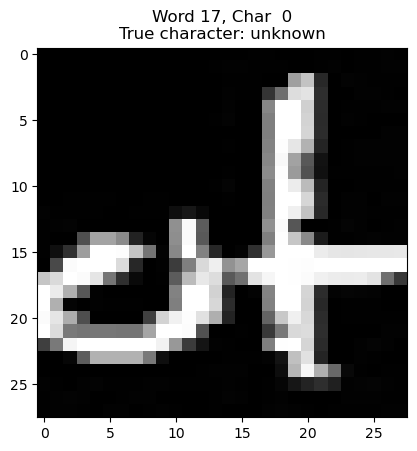

In [10]:
print("Char dataset shape: ", data.shape)
print("Words: ", len(words))

random_word = np.random.randint(0, len(words))
word = words[random_word]
random_char = np.random.randint(0, len(word))

char = word[random_char,:,:]
label = y_word[random_word][random_char]

if label == 99:
    true_char = 'unknown'
else:
    true_char = chars[label]

plt.imshow(char, cmap='gray')
plt.title('Word ' + str(random_word) + ', Char  '+ str(random_char)+'\nTrue character: '+str(true_char));

# Load EMNIST dataset

In [11]:
emnist = scipy.io.loadmat('data/training/emnist-letters.mat')
emnist_data = emnist['dataset']

X_train = emnist_data['train'][0,0]['images'][0,0]
y_train = emnist_data['train'][0,0]['labels'][0,0]

X_test = emnist_data['test'][0,0]['images'][0,0]
y_test = emnist_data['test'][0,0]['labels'][0,0]

## Create validation set
# val_start = X_train.shape[0] - X_test.shape[0]
# X_val = X_train[val_start:X_train.shape[0],:]
# y_val = y_train[val_start:X_train.shape[0]]
# X_train = X_train[0:val_start,:]
# y_train = y_train[0:val_start]


print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)

# print("X validation shape: ", X_val.shape)
# print("y validation shape: ", y_val.shape)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
#y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
#y_test = scaler.fit_transform(y_test)

X train shape:  (124800, 784)
y train shape:  (124800, 1)
X test shape:  (20800, 784)
y test shape:  (20800, 1)


Text(0.5, 1.0, 'Test Label: m, 13')

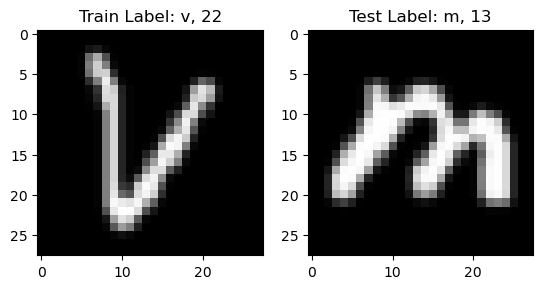

In [12]:
X_train = X_train.reshape((X_train.shape[0], 28, 28), order='F')
X_test = X_test.reshape((X_test.shape[0], 28, 28), order='F')

rand_train = np.random.randint(0, len(X_train))
rand_test = np.random.randint(0, len(X_test))

train_char = X_train[rand_train,:,:]
test_char = X_test[rand_test,:,:]

train_label_i = y_train[rand_train,0]
test_label_i = y_test[rand_test,0]
# Translate labels to letter
letters = 'abcdefghijklmnopqrstuvwxyz'
train_label = letters[train_label_i-1]
test_label = letters[test_label_i-1]

fig, axes = plt.subplots(1,2)
axes[0].imshow(train_char, cmap='gray')
axes[0].set_title(f'Train Label: {train_label}, {train_label_i}')
#plt.title(f'Label: {label}, {label_i}')
axes[1].imshow(test_char, cmap='gray')
axes[1].set_title(f'Test Label: {test_label}, {test_label_i}')

In [13]:
# X_test = X_test.reshape((X_test.shape[0], 28, 28), order='F')

# random_sample = np.random.randint(0, len(X_test))
# char = X_test[random_sample,:,:]
# label_i = y_test[random_sample,0]
# # Translate labels to letter
# letters = 'abcdefghijklmnopqrstuvwxyz'
# label = letters[label_i-1]

# plt.imshow(char, cmap='gray')
# plt.title(f'Label: {label}, {label_i}')



# Pre-training with EMNIST dataset

In [14]:
# Add channel dimension
X_train = X_train.reshape((X_train.shape[0],28,28,1))
X_test = X_test.reshape((X_test.shape[0],28,28,1))


model = K.models.Sequential([
    K.layers.Conv2D(72, (5,5), activation='relu', input_shape=X_train.shape[1:],kernel_regularizer=l2(0.0001)),
    K.layers.MaxPool2D((2,2)),
    K.layers.Conv2D(70, (3,3), activation='relu',kernel_regularizer=l2(0.0001)),
    K.layers.MaxPool2D((2,2)),
    K.layers.Conv2D(68, (3,3), activation='relu',kernel_regularizer=l2(0.0001)),
    K.layers.MaxPool2D((2,2)),
    K.layers.Flatten(),
    K.layers.Dropout(0.2),
    
    K.layers.Dense(145, activation='relu',kernel_regularizer=l2(0.01)),
    K.layers.Dense(len(letters) + 1, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-12-13 13:09:31.644598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-13 13:09:31.784183: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 72)        1872      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 72)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 70)        45430     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 70)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 68)          42908     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 68)          0

In [15]:

history = model.fit(X_train, y_train, epochs=10, batch_size=1000, verbose=2, validation_data=(X_test, y_test))

Epoch 1/10


2023-12-13 13:09:32.739140: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 391372800 exceeds 10% of free system memory.
2023-12-13 13:09:33.677592: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165888000 exceeds 10% of free system memory.
2023-12-13 13:09:33.984616: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165888000 exceeds 10% of free system memory.
2023-12-13 13:09:34.190815: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165888000 exceeds 10% of free system memory.
2023-12-13 13:09:34.361503: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 165888000 exceeds 10% of free system memory.


125/125 - 50s - loss: 2.1479 - accuracy: 0.5158 - val_loss: 1.0025 - val_accuracy: 0.7982 - 50s/epoch - 403ms/step
Epoch 2/10
125/125 - 52s - loss: 0.9442 - accuracy: 0.7847 - val_loss: 0.6546 - val_accuracy: 0.8594 - 52s/epoch - 414ms/step
Epoch 3/10
125/125 - 50s - loss: 0.7008 - accuracy: 0.8328 - val_loss: 0.5274 - val_accuracy: 0.8800 - 50s/epoch - 400ms/step
Epoch 4/10
125/125 - 50s - loss: 0.5882 - accuracy: 0.8531 - val_loss: 0.4604 - val_accuracy: 0.8884 - 50s/epoch - 397ms/step
Epoch 5/10
125/125 - 51s - loss: 0.5231 - accuracy: 0.8667 - val_loss: 0.4211 - val_accuracy: 0.8958 - 51s/epoch - 405ms/step
Epoch 6/10
125/125 - 52s - loss: 0.4855 - accuracy: 0.8730 - val_loss: 0.3930 - val_accuracy: 0.9020 - 52s/epoch - 412ms/step
Epoch 7/10
125/125 - 50s - loss: 0.4532 - accuracy: 0.8800 - val_loss: 0.3718 - val_accuracy: 0.9067 - 50s/epoch - 396ms/step
Epoch 8/10
125/125 - 50s - loss: 0.4331 - accuracy: 0.8853 - val_loss: 0.3628 - val_accuracy: 0.9079 - 50s/epoch - 396ms/step
Epo

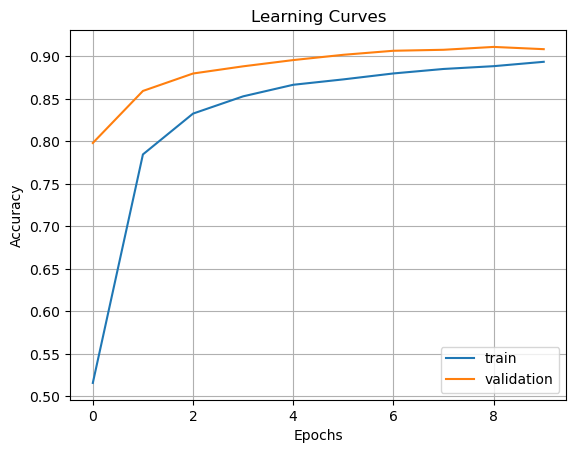

In [16]:
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

In [17]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100}')
model.save("model")

Accuracy: 90.86057543754578
INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


# Predict our own handwritten characters

In [18]:
print("Word datasets:")
for i, word in enumerate(words):
    print(f"Word {i}: {word.shape}")

Word datasets:
Word 0: (4, 28, 28)
Word 1: (4, 28, 28)
Word 2: (5, 28, 28)
Word 3: (1, 28, 28)
Word 4: (3, 28, 28)
Word 5: (7, 28, 28)
Word 6: (4, 28, 28)
Word 7: (2, 28, 28)
Word 8: (1, 28, 28)
Word 9: (5, 28, 28)
Word 10: (3, 28, 28)
Word 11: (3, 28, 28)
Word 12: (4, 28, 28)
Word 13: (5, 28, 28)
Word 14: (1, 28, 28)
Word 15: (5, 28, 28)
Word 16: (4, 28, 28)
Word 17: (1, 28, 28)
Word 18: (4, 28, 28)
Word 19: (5, 28, 28)
Word 20: (6, 28, 28)
Word 21: (7, 28, 28)
Word 22: (2, 28, 28)
Word 23: (8, 28, 28)
Word 24: (4, 28, 28)
Word 25: (5, 28, 28)
Word 26: (4, 28, 28)
Word 27: (4, 28, 28)
Word 28: (1, 28, 28)
Word 29: (3, 28, 28)
Word 30: (7, 28, 28)
Word 31: (1, 28, 28)
Word 32: (3, 28, 28)
Word 33: (4, 28, 28)


In [19]:
final_predictions = []
# Reshape all datasets and make predictions
for i, word in enumerate(words):
    word = word.reshape(word.shape[0],28,28,1)
    probas = model.predict(word, verbose=0)
    prediction_indices = [np.argmax(p) for p in probas]
    predicted_chars = [chars[x-1] for x in prediction_indices]
    final_predictions.append(predicted_chars)

print(final_predictions)

## Make long list of predictions
all_preds = []
for j,entry in enumerate(final_predictions):
    for i in range(0,len(entry)):
        all_preds.append(entry[i])

output_file = open('output.txt', 'w')
for i, word in enumerate(final_predictions):
    if i > 0: output_file.writelines(' ')
    for n,char in enumerate(word):
        output_file.writelines(char)
        # if y_word[i][n] == 99:
        #     output_file.writelines('_')
        # else:
        #     output_file.writelines(char)
        
output_file.close()

#all_preds

[['h', 'o', 'p', 'c'], ['t', 'h', 'j', 'f'], ['w', 'm', 'k', 's', 'i'], ['f'], ['i', 'n', 'a'], ['p', 'r', 'p', 'j', 'c', 'e', 't'], ['t', 'h', 'i', 't'], ['i', 't'], ['a'], ['m', 'm', 'p', 'i', 'e'], ['u', 'x', 't'], ['t', 'h', 'f'], ['h', 'm', 't', 'n'], ['x', 'i', 'i', 'p', 'f'], ['a'], ['t', 'h', 'j', 'f', 'd'], ['l', 'i', 'n', 'c'], ['w'], ['t', 'c', 'x', 't'], ['f', 'j', 'r', 'a', 'l'], ['m', 'c', 'f', 'f', 'a', 'j'], ['s', 'p', 'a', 'f', 'i', 'd', 'g'], ['i', 'i'], ['i', 'm', 't', 'r', 'f', 'a', 't', 't'], ['h', 'e', 'i', 'e'], ['w', 'e', 'f', 'i', 'd'], ['h', 'e', 'p', 'e'], ['t', 'i', 't', 'e'], ['f'], ['n', 'a', 'l'], ['p', 'r', 'a', 'j', 'e', 'f', 't'], ['a'], ['o', 'r', 'k'], ['w', 'c', 'i', 'i']]


Text(0.5, 1.0, 'Word: 16 Char: 3\nPredicted: c, True: e')

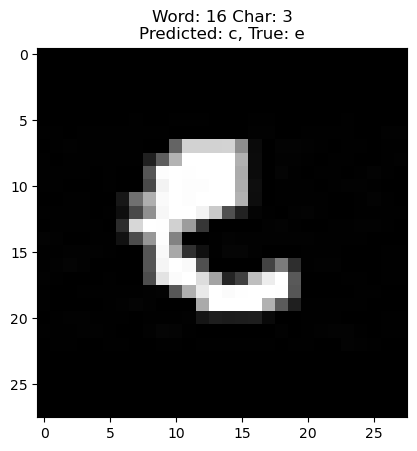

In [20]:
for i, word in enumerate(words):
    word = word.reshape(word.shape[0],28,28)

random_word = np.random.randint(0, len(words))
word = words[random_word]
random_char = np.random.randint(0, len(word))
char = word[random_char,:,:]

label = y_word[random_word][random_char]
if label == 99:
    true_char = 'unknown'
else:
    true_char = chars[label]

plt.imshow(char, cmap='gray')
plt.title(f"Word: {random_word} Char: {random_char}\nPredicted: {final_predictions[random_word][random_char]}, True: {true_char}")

## Confusion Matrix

In [21]:
def to_char(index):
    if index == 99:
        return '-'
    else:
        return chars[index]

y_true = [to_char(x) for x in y]
y_pred = all_preds


## Locate misclassified characters
df = pd.DataFrame(columns=['Pred', 'True'])
df.loc[:,'True'] = y_true
df.loc[:,'Pred'] = y_pred
misclassified = df[df['Pred'] != df['True']]
acc = 1-(len(misclassified)/len(y_pred))

## Confusion matrix
set_total = set(y_pred).union(set(y_true))
labels = sorted(list(set_total))

cm = metrics.confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square=True);
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0:.2f}'.format(acc*100), size=12);
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
print(f"Misclassified: {len(misclassified)}")
misclassified

Misclassified: 50


,Pred,True
3,c,e
6,j,i
7,e,s
9,m,-
12,y,-
14,x,l
22,e,c
25,n,h
27,i,s
31,w,-


In [ ]:
## Dictionary with frequency of misclassified characters
dict = {}
num_undefined = 0
for i in range(0,len(misclassified)):
    true = misclassified.iloc[i,1]
    if true == '-':
        num_undefined += 1
    pred = misclassified.iloc[i,0]
    dict[pred] = dict.get(pred,0) + 1

print(f"Number of undefined characters: {num_undefined}")
acc2 = 1 - ((len(misclassified)-num_undefined) / (len(y_pred)-num_undefined))
print(f"Accuracy disregarding undefined characters: {acc2}")
dict

Number of undefined characters: 12
Accuracy disregarding undefined characters: 0.6779661016949152


{'c': 4,
 'j': 5,
 'e': 10,
 'm': 1,
 'y': 2,
 'x': 2,
 'n': 2,
 'i': 12,
 'w': 3,
 'v': 1,
 'h': 1,
 'f': 1,
 'g': 2,
 'd': 1,
 'a': 2,
 's': 1}

## Save Model and export output

In [ ]:
model.save("model")
model = K.models.load_model('model')
x = model.layers[-3].output 
model = K.Model(inputs = model.input, outputs = x)
model.summary()

training_data=[]
model_training_output=[]
#for word in words:
#    training_data.append(word.reshape(word.shape[0],28,28,1))
#    probas = model.predict(word, verbose=0)
#    prediction_indices = [np.argmax(p) for p in probas]
#    predicted_chars = [chars[x] for x in prediction_indices]
#    model_training_output.append(predicted_chars)
   

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 72)        1872      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 12, 12, 72)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 10, 10, 70)        45430     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 5, 5, 70)          0         
 ng2D)                                                           
                                                           